# Программа для распознавания движения по картинкам

## Зависимости

Для работы нам потребуются несколько библиотек

Для установки [Pythonъ](https://www.python.org/downloads/) перейдите по ссылке.

Далее для установки всех пакетов, выполните: 

```pip install jupyter jupyterlab ipycanvas ipywidgets numpy pillow matplotlib```

Для включения канвы и интерактивчика в блокнотах, последовательно выполните:

```sudo jupyter labextension install ipycanvas @jupyter-widgets/jupyter-manager```

, а затем:

```jupyter nbextension enable widgetsnbextension```

## Сама программа

Сначала подключим нужные библиотеки:

In [1]:
import typing # Статическая типизация
import IPython.display # Вывод изображений сюда

import numpy as np # Обработка массивов
from PIL import Image # Загрузка изображений с диска, преобразование массива в картинку
import math # Простые математические операторы

## Подготовка ресурсов

Сейчас нам нужно считать картинку с диска и записать ее в виде двумерного массива, для последующей обработки. Для этого мы воспользуемся библиотеками ```Pillow``` и ```numpy```, которые подключили ранее

In [2]:
image = Image.open("floor.bmp") # Считываем картинку в переменную

data: np.ndarray = np.array(image) # Преобразовываем картинку в двумерный массив с тройками чисел, обозначающими цвета

Создадим функцию, которая будет выводить массив как картинку сюда. Это нужно для сокращение количества кода. Также сразу ее запустим, чтобы убедиться, что она работает.

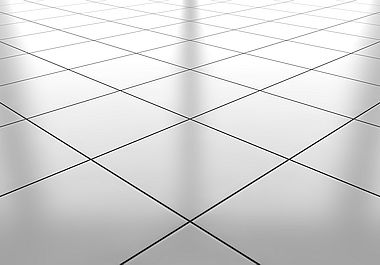

In [3]:
def display_image(array: np.ndarray, format="png"):
    """Показать картинку"""
    IPython.display.display(Image.fromarray(array.astype(np.uint8)))

display_image(data) # Выводим картинку:

## Преобразование в черно-белое
### Теория цветов

Для представления картнки на компьютере используються ***светодиоды 3 цветов: красного, зеленого и синего***. 

![](../../materials/RGB_example.png)

> Пиксел - совокупность светодиодов трех цветов

С помощью зажигания светодиодов монитора соответствующих цветов с различной интенсивностью можно выразить множество цветов. В нашем конкретном случае *диапазон цветов будет от 0 до 255*, а значит, у нас будет *примерно 16 миллионов цветов*. 

Компьютеру будет очень сложно обсчитывать такой объем данных, потому мы превратим нашу картинку в черно-белую.

Представим, что $R$ - количество красного цвета пикселя, $G$ - количество зеленого цвета пикселя, $B$ - количество синего цвета пикселя.
Тогда яркость пикселя в черно-белом диапазоне будет равна $W$, которую можно найти по формуле:

(1) $W = \frac{R + G + B}{3}$
или
(2) $W = c_1 * R + c_2 * G + c_3 * B$, где $c_1, c_2, c_3$ - некоторые коэфиценты

### Практика

Реализуем функцию, которая будет обрабатывать все пиксели массива ```array``` используя функцию ```func```.

In [4]:
def apply_to(array: np.ndarray, func) -> np.ndarray:
    """Применить функцию ко всем элементам массива"""
    vect_func = np.vectorize(func)
    return vect_func(array)

def apply_to_array(array: np.ndarray, func, dimension=-1) -> np.ndarray:
    """Применить функцию с массиву с ```dimension``` измерений"""
    return np.apply_along_axis(func, dimension, array)

def display_wb_image(array: np.ndarray) -> np.ndarray:
    """Отобразить двумерный массив чисел как картинку"""
    new_image = apply_to_array(array, lambda x: np.array(list(map(lambda y: [y] * 3, x))))
    display_image(new_image)

Я написал 2 варианта функции, одна оптимизирована и мы ее будем использовать, как только преобразуем данные из RGB в черно - белые.

Теперь преобразуем все пиксели в черно-белые.

### Протестируем оба способа
#### Первый способ

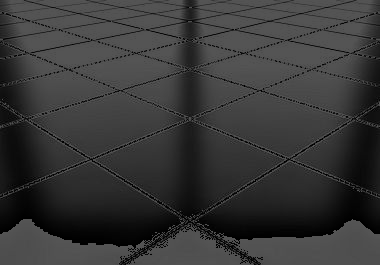

In [5]:
wb_1: np.ndarray = apply_to_array(data, lambda x: int((x[0] + x[1] + x[2]) / 3))
"""Черно-белое изображение, полученное средним значением цветов из каналов"""

# Выводим изображение
display_wb_image(wb_1)

#### Второй способ

- Коэфициенты: $c_1 = 0,2126$, $c_2 = 0.7152$, $c_3 = 0.0722$

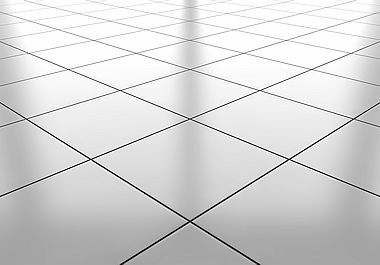

In [6]:
c1_1 = 0.2126
c2_1 = 0.7152
c3_1 = 0.0722

wb_2_1: np.ndarray = apply_to_array(data, lambda x: int(c1_1 * x[0] + c2_1 * x[1] + c3_1 * x[2]))
"""Ч/Б изображение, полученное с помощью умножения каналов на константы ```cn_1```"""

# Выводим изображение
display_wb_image(wb_2_1)

- Коэфициенты: $c_1 = 0,299$, $c_2 = 0,587$, $c_3 = 0,114$

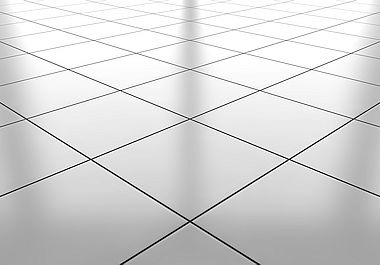

In [7]:
c1_2 = 0.299
c2_2 = 0.587
c3_2 = 0.114

wb_2_2: np.ndarray = apply_to_array(data, lambda x: int(c1_2 * x[0] + c2_2 * x[1] + c3_2 * x[2]))
"""Ч/Б изображение, полученное с помощью умножения каналов на константы ```cn_2```"""

# Выводим картинку
display_wb_image(wb_2_2)

Как можно заметить, хоть вторая формула получения черно-белого изображения *сложнее*, но результат получается *лучше*.

Мне нравится первая картинка второго пункта, ее и будем использовать дальше

In [8]:
data_wb: np.ndarray = wb_2_1
"""Итоговая картинка черно-белого изображения"""

'Итоговая картинка черно-белого изображения'

## Очистка от щумов

### Теория фильтров

Для того, чтобы на картинке отсутствовали артефакты и шумы, нужно эту картинку отфильтровать.

> Фильтр (от лат. filtrum — «войлок») — устройства, созданные для отделения чего-то от чего-то. Механизмы выделяющие (или удаляющие) из исходного объекта некоторую часть с заданными свойствами.

Мы будем фильтровать шумы следующим способом:

1. Обозначим пиксель в позиции $x, y$, как $I_{xy}$
2. Для всех окружающих его пикскелей в радиусе $R$ считаем:
    - Сумму: ($S$) прилежащих пикселей в квадрате состороной $R$, а затем:
    - *Либо* среднее значение $\frac{S}{R^2}$
    - *Либо* медианное значение $n$, при котором выполено условие $|\{x < n | x \in S\}| = |\{x > n | x \in S\}|$
3. На место этого пикселя ставим полученное значение

### Приминение теории

Реализуем функцию, которая будет брать матрицу нужного нам размера $R$ из катринки

In [9]:
def get_subdata(data: np.ndarray, x: int, y: int, R: int) -> np.ndarray:
    """Взятие квадрата с данными по координатам ```x, y``` со стороной ```R```"""
    
    # "Радиус" квадрата
    half_R = R // 2 

    # Срез по +-радиус квадрата <=> квадрат со стороной R
    return data[(x - half_R):(x + half_R + 1), (y - half_R):(y + half_R + 1)] 

#### Фильтрование по среднему

Напишем функцию, которая будет фильтровать массив ```data``` по нашей формуле при $R$ = ```R```

In [10]:
def filter_data(data: np.ndarray, R: int, func) -> np.ndarray:
    """Линейно фильтруем данные ```data```, \
    размер промежуточной матрицы - ```R```, \
    с помощью пользовательской функции ```func```"""

    R = R - R % 2 + 1 # Теперь у нас R будет строго нечетным (середина + 2 половинки)
    half_R = R // 2 # Половинка
    
    # Заполняем края нулями
    data_0 = np.pad(data, pad_width=half_R, mode="constant", constant_values=0)

    # Применяем функцию -> Преобразуем в список -> Преобразуем в np.ndarray
    filtered_array: np.ndarray = np.array(list(map( # Преобразования типов
        lambda info: # Функция, обрабатывающая данный
            int(func(get_subdata(data_0, # Приминяем пользовательскую функцию к данным
                    info[0][0] + half_R, # X
                    info[0][1] + half_R, R))), # Y, R 
        np.ndenumerate( # Составляем массив индекс-значение
            data_0
                [half_R:-half_R, 
                half_R:-half_R]))))

    # Получаем размеры изображения
    size = data.shape[0], data.shape[1] 

     # Преобразуем изображение в известный нам размер
    filtered_data = np.reshape(filtered_array, size)

    return filtered_data

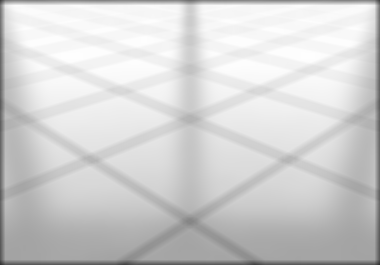

In [11]:
filter_mean = filter_data(data_wb, 10, lambda x: x.mean())
"""Изображение, фильтрованное от шумов по среднему"""

# Отображаем картинку
display_wb_image(filter_mean)

#### Фильтрование по медиане

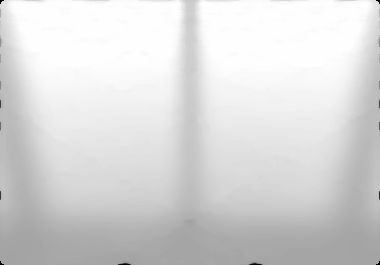

In [12]:
filter_median: np.ndarray = filter_data(data_wb, 8, lambda x: np.median(x))
"""Изображение, фильтрованное от шумов по медиане"""

# Выводим изображение
display_wb_image(filter_median)

### Вывод

Можно заметить, что при исользовании среднего значения качество ухучшается гораздо быстрее, а потому мы будем использовать медианный фильтр со значением $R = 3$

In [13]:
data_fitered: np.ndarray = filter_data(data_wb, 3, lambda x: np.median(x))
"""Итоговое фильтрованное изображение"""

'Итоговое фильтрованное изображение'

## Преобразование в 0 и 1

### Теория нормирования

Нам нужно преобразовать картинки их *8-битного* двоичного числа (значения - $\{0, 1, \dots, 2^8 - 1\} = \{0, 1, \dots, 255\}$) в *1-битное* (значения - $\{0,\dots, 2^1 - 1\} = \{0, 1\}$).

Если бы у нас хранились *не целые числа, а дробные*, по надо бы было просто разделить значения всех пикселей на максимальное значение (255 в нашем случае), но **мы используем целые числа, а потому нам нужно выполнить другое преобразование**.

Для такого преобразования нужно выбрать число $c$ (некое среднее значение) и выполнить такую функцию:

$f(x) = 0, x <= c$

То есть, если значение пикселя ***меньше или равно*** $c$, то ставить 0

и

$f(x) = 1, x > c$

Если значение пикселя ***больше*** $c$, то ставить 1

#### Выбор среднего значения

Только как нам выбрать $c$, чтобы все выглядело нормально? Для этого есть два способа:

1. Выбрать медианное значение
2. Выбрать среднее значение

Мы попробуем оба способа.

Выбрать среднее значение можно 2 способами: 

1. (быстрый) Просто предположить, что среднее всех пикселей примерно *равно среднему из максимального возможного значения и минимального возможного значения*
2. Считать *среднее по всем значениям пикселей*

Для выбора *медианного значения* существует только *1 способ*.

### Приминение теории

Создадим функцию-аналог нашей фунции $f$, но она будет работать по всем числам, представляющим значения сразу.

In [14]:
def normalize(data: np.ndarray, c: int) -> np.ndarray:
    """Преобразование черно-белого изображения из 8битового в 1битное"""

    # Функция сверения с порогом ```с```
    f = lambda x: 0 if x <= c else 1

    # Попиесельное применение к ```data```
    return apply_to(data.astype(np.uint0), f)

Напишем также функцию, которая будет выводить картинку в новом, однобитном формате на экран

In [15]:
def display_u1_data(data: np.ndarray):
    """Орображение 1битового изображения"""
    display_wb_image(data * 255) # 0 * 255 -> 0; 1 * 255 -> 255

#### Среднее значение

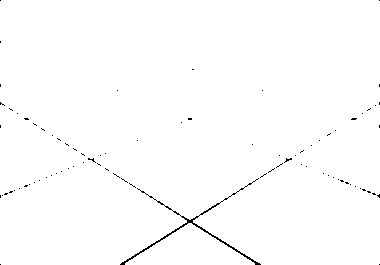

In [19]:
norm_1 = normalize(data_fitered, 128) # 128 = 0 + 256 / 2
"""1битное изображение, по среднему"""

# Отображаем результат
display_u1_data(norm_1)

#### Медианное значение

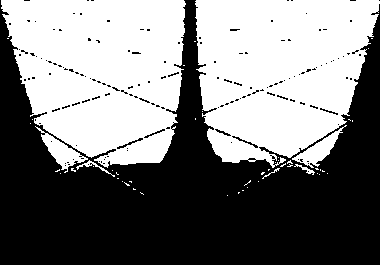

In [20]:
norm_2 = normalize(data_fitered, np.median(data_fitered))
"""1битное изображение, полученное по медиане"""

# Выводим картинку
display_u1_data(norm_2)

### Вывод

Нормирование по медиане оставляет лучший результат, чем среднее, так что будем использовать его

In [21]:
data_normed: np.ndarray = norm_2
"""Итоговое изображение после нормализации"""

'Итоговое изображение после нормализации'

## Выделение границ

### Теория. Фильтр Собеля

> Оператор Собеля — дискретный дифференциальный оператор, вычисляющий приближённое значение градиента яркости изображения.

Вот способ его работы:

Исходные данные:

изображение $A^{N⋅M}$
Вычисляемые данные:

матрица аппроксимации модуля градиента $G^{N⋅M}$
матрица аппроксимации направления градиента $Θ^{N⋅M}$
Это матрицы такого же размера, как исходное изображение, так как параметры градиента вычисляются для каждого пикселя изображения.

Промежуточные горизонтальные и вертикальные производные вычисляются с помощью следующих двумерных сверток:

$F = 
\begin{bmatrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}$

$G_x=F∗A, G_y=F^T∗A$

Аппроксимации для модуля и направления градиента можно получить, скомбинировав эти производные:

$G=G_x^2+G_y^2$

$Θ=\arctan{\frac{G_y}{G_x}}$

### Применение теории

In [22]:
sobel_matrix: np.ndarray = np.array([
    [1,   2,  1],
    [0,   0,  0],
    [-1, -2, -1]])
"""Матрица со специальными значениями для фильтра"""

sobel_matrix_T: np.ndarray = sobel_matrix.transpose()
"""Транспонированая матрица фильтра Собеля"""

def sobel_filter(data: np.ndarray) -> int:
    """Фильтруем фрагмент (```data```) с помощьб фильтра собеля"""

    Gx: int = np.sum(data * sobel_matrix) # Изменение по X
    Gy: int = np.sum(data * sobel_matrix_T) # Изменение по Y

    return int(math.hypot(Gx, Gy)) # По теореме пифагора находим результат

data_sobel: np.ndarray = filter_data(data_normed, 3, sobel_filter)

data_sobel_norm: np.ndarray = (data_sobel / np.max(data_sobel)).astype(np.uint0)

In [23]:
data_sobel_norm

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint64)

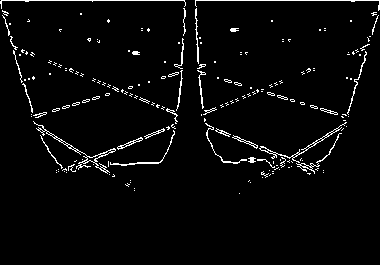

In [24]:
display_u1_data(data_sobel_norm)